In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import lightgbm  as lgb
from sklearn.model_selection import learning_curve
from sklearn.metrics         import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler


In [216]:
url = 'https://raw.githubusercontent.com/modousalla/covid-19/main/dataset/dataset.csv'
data = pd.read_csv(url, index_col=0, encoding = "ISO-8859-1")


**Pre - processing**

In [217]:
df = data.copy()
df_ = data.copy()

**Création des sous-ensembles**

In [218]:
missing_rate = df.isna().sum()/df.shape[0]

In [219]:
blood_columns = list(df.columns[(missing_rate < 0.9) & (missing_rate >0.88)])
viral_columns = list(df.columns[(missing_rate < 0.80) & (missing_rate > 0.75)])

In [220]:
key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

In [221]:
df = df[key_columns + blood_columns + viral_columns]

**TrainTest - Nettoyage - Encodage**

In [222]:
trainset, testset = train_test_split(df, test_size=0.2, random_state=0)

In [223]:
trainset['SARS-Cov-2 exam result'].value_counts()

negative    4068
positive     447
Name: SARS-Cov-2 exam result, dtype: int64

In [224]:
testset['SARS-Cov-2 exam result'].value_counts()

negative    1018
positive     111
Name: SARS-Cov-2 exam result, dtype: int64

In [225]:
# Drop null columns
drop_list = ['D-Dimer','Prothrombin time (PT), Activity', 'Partial thromboplastin time\xa0(PTT)\xa0', 'Urine - Sugar', 'Fio2 (venous blood gas analysis)']
df_ = df_.drop(drop_list, axis=1)

# Fill NaNs with -10
df_ = df_.fillna(-10, axis=1)

# Binarize SARS-Cov-2 label
df_['SARS-Cov-2 exam result'] = np.where(df['SARS-Cov-2 exam result'] == 'positive',1,0)

# Compact care unit label
df_['Care_unit'] = np.where(df_['Patient addmited to intensive care unit (1=yes, 0=no)'] == 1,2,
                                  np.where(df_['Patient addmited to semi-intensive unit (1=yes, 0=no)'] == 1,1,0))

# Drop care unit columns
drop_list = ['Patient addmited to regular ward (1=yes, 0=no)', 'Patient addmited to semi-intensive unit (1=yes, 0=no)', 'Patient addmited to intensive care unit (1=yes, 0=no)']
df_ = df_.drop(drop_list, axis=1)

In [226]:
colnames  = df_.columns[(df_.dtypes == 'O').tolist()].tolist()
df_.drop(colnames, axis = 1, inplace = True)

In [227]:
train_df, test_df = train_test_split(df_,
                                     stratify     = df['SARS-Cov-2 exam result'],
                                     test_size    = 0.2,
                                     random_state = 451
                                     )

In [228]:
train_label = train_df.pop('SARS-Cov-2 exam result')
test_label  = test_df.pop('SARS-Cov-2 exam result')

In [229]:
cols_list = train_df.columns.tolist()
train_df.columns = list(range(train_df.shape[1]))
test_df.columns  = list(range(test_df.shape[1]))

In [230]:
lgb_train = lgb.Dataset(train_df, label = train_label)
lgb_test  = lgb.Dataset(test_df,  label = test_label)

In [231]:
params = {'num_leaves': 173,
            'min_child_weight': 0.0,
            'feature_fraction': 0.37030374041940073,
            'bagging_fraction': 1.0,
            'scale_pos_weight': 3.1711826966844865,
            'reg_lambda': 40.72176285252339,
            'reg_alpha': 10.0,
            'min_data_in_leaf': 9,
            'objective': 'binary',
            'max_depth': -1,
            'learning_rate': 0.006214136848886512,
            'boosting_type': 'gbdt',
            'bagging_seed': 42,
            'metric': 'auc',
            'verbosity': -1,
            'random_state': 451,
               }

In [232]:
lgb_model = lgb.train(params,
                      lgb_train,
                      10000,
                      valid_sets   = [lgb_train],
                      verbose_eval = 1000
                     )

[1000]	training's auc: 0.704403
[2000]	training's auc: 0.711519
[3000]	training's auc: 0.713036
[4000]	training's auc: 0.712896
[5000]	training's auc: 0.713761
[6000]	training's auc: 0.713732
[7000]	training's auc: 0.713757
[8000]	training's auc: 0.713755
[9000]	training's auc: 0.713754
[10000]	training's auc: 0.713754


In [233]:
def visualize(traintestset):

  # Summarise data
  count_df = pd.DataFrame(traintestset.value_counts()).reset_index()
  count_df.columns = ['Label','Count']
  count_df = count_df.iloc[::-1]

  # Create annotations
  annotations = [dict(
              y=count_df.loc[i,'Label'],
              x=count_df.loc[i,'Count'] + 150,
              text=str(round(count_df.loc[i,'Count']/5644*100,1))+'%',
              font=dict(
              size=14,
              color="#000000"
              ),
              bordercolor="#c7c7c7",
              borderwidth=1,
              borderpad=4,
              bgcolor="#ffffff",
              opacity=0.95,
              showarrow=False,
          ) for i in range(count_df.shape[0])]

  # Generate Plot
  fig = px.bar(count_df,
              y='Label',
              x='Count',
              orientation='h',
              title='Label Distribution of SARS-Cov-2',
              template='plotly_dark'
              )
  fig.update_layout(annotations = annotations)
  fig.update_traces(marker_color='#35bdcc',
                    #marker_line_color='#ffffff',
                    #marker_line_width=1,
                    opacity=0.8)

  fig.show()

  return ;

In [234]:
visualize(trainset['SARS-Cov-2 exam result'])

In [235]:
visualize(testset['SARS-Cov-2 exam result'])

In [236]:
px.box(df,
       x = 'SARS-Cov-2 exam result',
       y='Patient age quantile',
       color='SARS-Cov-2 exam result',
       title='Age Quantile vs COVID-19 Exam Result',
       template='plotly_dark',
       color_discrete_sequence=['#dbdbdb','#38cae0'],
       width=800
      )


In [237]:
def preprocessing(df):
    code = {'negative':0,
            'positive':1,
            'not_detected':0,
            'detected':1}
    
    for col in df.select_dtypes('object').columns:
        df.loc[:,col] = df[col].map(code)
    
    df['est malade'] = df[viral_columns].sum(axis=1) >= 1
    df = df.drop(viral_columns, axis=1)
    df = df.dropna(axis=0)
    X = df.drop('SARS-Cov-2 exam result', axis=1)
    y = df['SARS-Cov-2 exam result']
    
    print(y.value_counts())
    
    return X, y

In [238]:
X_train, y_train = preprocessing(trainset)

0    422
1     65
Name: SARS-Cov-2 exam result, dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [239]:
X_test, y_test = preprocessing(testset)

0    95
1    16
Name: SARS-Cov-2 exam result, dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



**Procédure d'évaluation**

In [240]:
def evaluation(model):
    
    model.fit(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred))
    print(classification_report(y_test, ypred))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()
    
    

In [241]:
def evaluate_model(preds, eval_df = test_label):
    '''
    Evaluate Predictions Function
    Returns accuracy and auc of the model
    '''
    auroc = roc_auc_score(eval_df.astype('uint8'), preds)
    accur = accuracy_score(eval_df.astype('uint8'), preds >= 0.5)
    print('Accuracy: ' + str(accur))
    print('AUC: ' + str(auroc))

**Modélisation**

* **Pipeline**   



In [242]:
preprocessor = make_pipeline(PolynomialFeatures(2, include_bias=False), SelectKBest(f_classif, k=10))

In [243]:
RandomForest = make_pipeline(preprocessor, RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(preprocessor, AdaBoostClassifier(random_state=0))
SVM = make_pipeline(preprocessor, StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(preprocessor, StandardScaler(), KNeighborsClassifier())
LGBM = make_pipeline(preprocessor, StandardScaler(), lgb.LGBMClassifier())

In [244]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN,
                  'LGBM': LGBM
                 }

RandomForest
[[91  4]
 [11  5]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        95
           1       0.56      0.31      0.40        16

    accuracy                           0.86       111
   macro avg       0.72      0.64      0.66       111
weighted avg       0.84      0.86      0.85       111

AdaBoost
[[91  4]
 [ 9  7]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93        95
           1       0.64      0.44      0.52        16

    accuracy                           0.88       111
   macro avg       0.77      0.70      0.73       111
weighted avg       0.87      0.88      0.87       111

SVM
[[92  3]
 [10  6]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93        95
           1       0.67      0.38      0.48        16

    accuracy                           0.88       111
   macro avg       0.78      0.67      0.71  

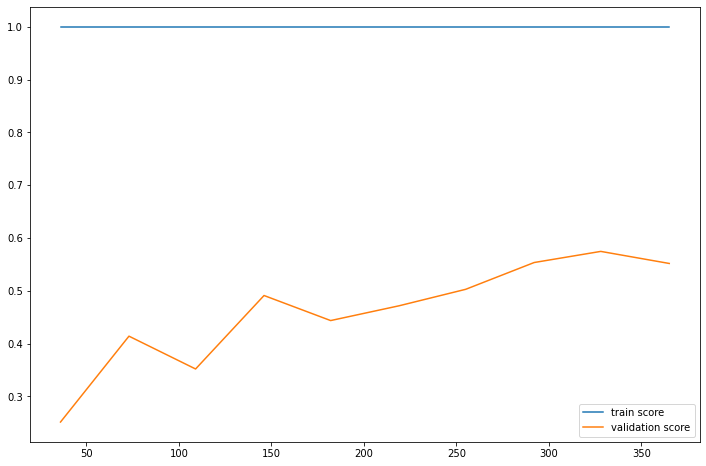

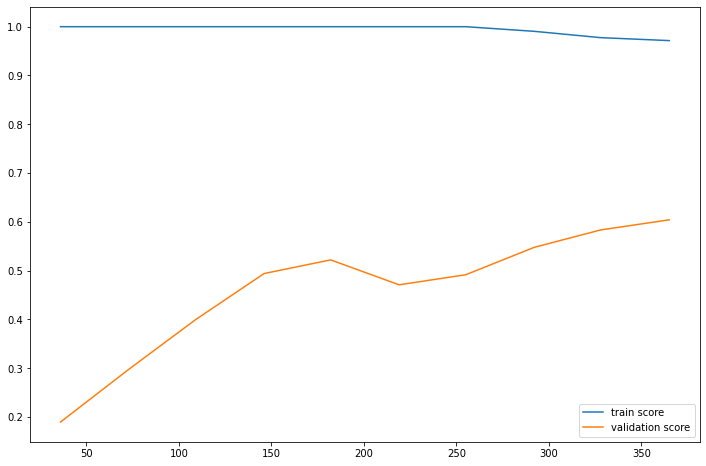

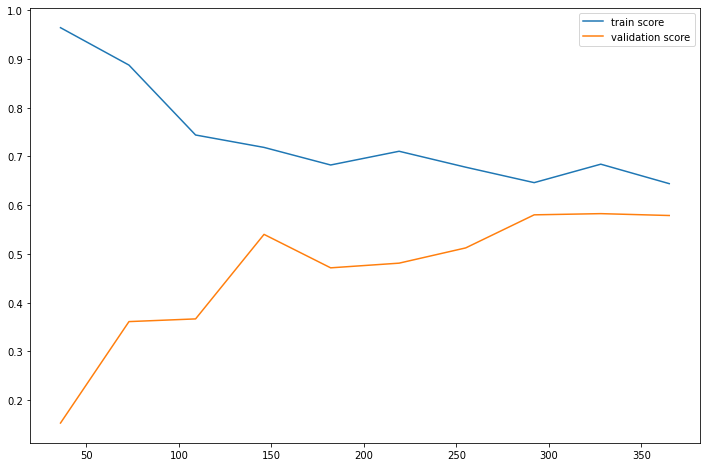

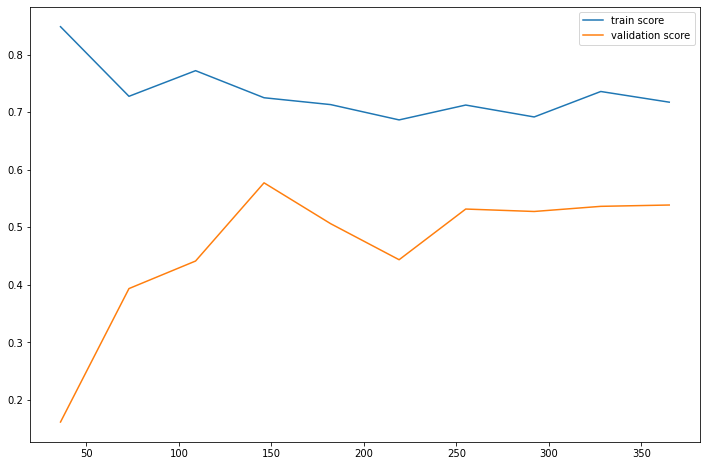

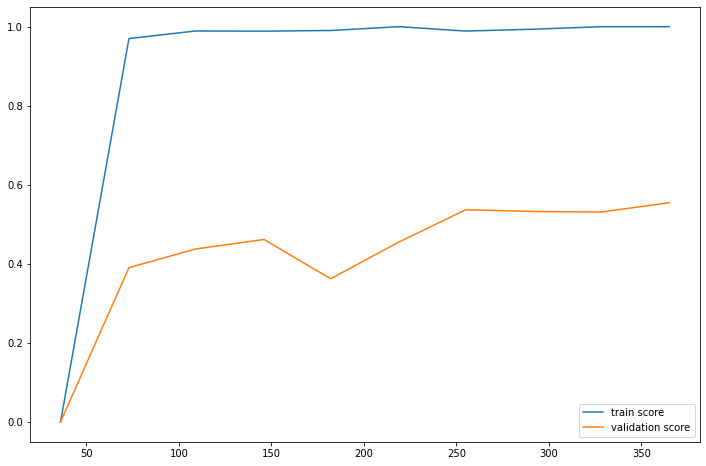

In [245]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

* **LGBM** 

In [246]:
lgb_preds = lgb_model.predict(test_df)
evaluate_model(lgb_preds)

Accuracy: 0.8990256864481843
AUC: 0.6661662452591656


**Optimisation**

In [247]:
hyper_params = {'svc__gamma':[1e-3, 1e-4, 0.0005],
                'svc__C':[1, 10, 100, 1000, 3000], 
               'pipeline__polynomialfeatures__degree':[2, 3],
               'pipeline__selectkbest__k': range(45, 60)}

In [248]:
grid = RandomizedSearchCV(SVM, hyper_params, scoring='recall', cv=4,
                          n_iter=40)

grid.fit(X_train, y_train)

print(grid.best_params_)

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))


{'svc__gamma': 0.001, 'svc__C': 1000, 'pipeline__selectkbest__k': 51, 'pipeline__polynomialfeatures__degree': 3}
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        95
           1       0.57      0.50      0.53        16

    accuracy                           0.87       111
   macro avg       0.74      0.72      0.73       111
weighted avg       0.87      0.87      0.87       111



[[89  6]
 [ 8  8]]
              precision    recall  f1-score   support

           0       0.92      0.94      0.93        95
           1       0.57      0.50      0.53        16

    accuracy                           0.87       111
   macro avg       0.74      0.72      0.73       111
weighted avg       0.87      0.87      0.87       111



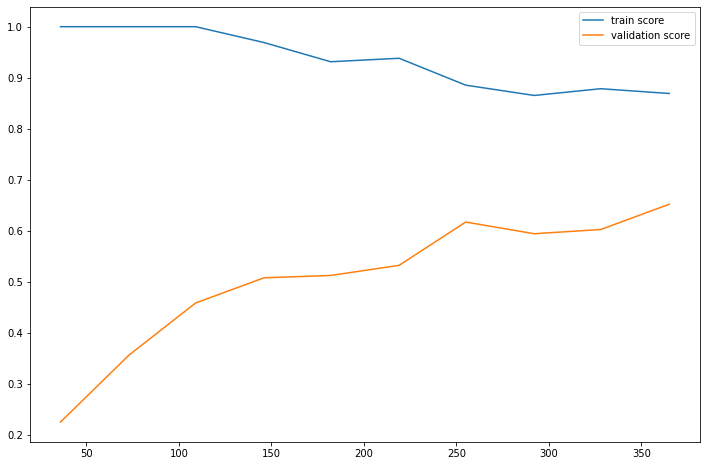

In [249]:
evaluation(grid.best_estimator_)

**Precision Recall Curve**

In [250]:
precision, recall, threshold = precision_recall_curve(y_test, grid.best_estimator_.decision_function(X_test))

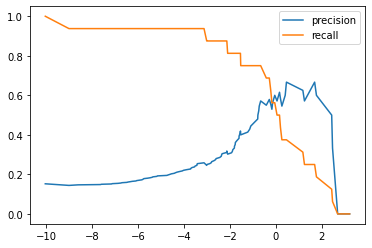

In [251]:
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.legend()

In [252]:
def model_final(model, X, threshold=0):
    return model.decision_function(X) > threshold

In [253]:
y_pred = model_final(grid.best_estimator_, X_test, threshold=-1)

In [254]:
f1_score(y_test, y_pred)

0.5714285714285714

In [255]:
recall_score(y_test, y_pred)

0.75

In [256]:
f1_score(y_test, y_pred)

0.5714285714285714

In [257]:
recall_score(y_test, y_pred)

0.75

**Bloodwork Model**

In [258]:
bloodwork_df = df_.query("Leukocytes > -10 and Monocytes >-10")
bloodwork_df['SARS-Cov-2 exam result'] = bloodwork_df['SARS-Cov-2 exam result'].astype('str')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [259]:
keep_list = ['Patient age quantile',
 'SARS-Cov-2 exam result',
 'Hematocrit',
 'Hemoglobin',
 'Platelets',
 'Mean platelet volume ',
 'Red blood Cells',
 'Lymphocytes',
 'Mean corpuscular hemoglobin concentration\xa0(MCHC)',
 'Leukocytes',
 'Monocytes',
 'Basophils',
 'Red blood cell distribution width (RDW)',
 'Mean corpuscular volume (MCV)',
 'Eosinophils',
 'Mean corpuscular hemoglobin (MCH)'
]

In [260]:
px.scatter_3d(bloodwork_df,
              y="Patient age quantile",
              z="Leukocytes",
              x="Monocytes",
              color='SARS-Cov-2 exam result',
              opacity=0.7,
              color_discrete_map = {"0": "#dbdbdb", "1":"#38cae0"},
              template='plotly_dark'
             )

In [261]:
def engineer_features(df):
    df['volume']     = 1/((df['Platelets']+10) * (df['Mean platelet volume ']+10))
    df['blood_var1'] = (df['Hematocrit']+10)/(df['Hemoglobin']+10)
    df['blood_var2'] = (df['Lymphocytes']+10) / (df['volume']+10)
    df['blood_var3'] = df['Leukocytes'] / df['volume']
    return(df)

In [262]:
bloodwork_df = engineer_features(bloodwork_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [263]:
# Create train and testing set for bloodwork dataset
blood_train_df, blood_test_df = train_test_split(bloodwork_df,
                                                 test_size = 0.3,
                                                 stratify  = bloodwork_df['SARS-Cov-2 exam result'],
                                                 random_state = 451
                                                )

In [264]:
blood_train_label = blood_train_df.pop('SARS-Cov-2 exam result').astype('int')
blood_test_label  = blood_test_df.pop('SARS-Cov-2 exam result').astype('int')

# Rename columns
blood_train_df.columns = list(range(blood_train_df.shape[1]))
blood_test_df.columns  = list(range(blood_test_df.shape[1]))

# Create lgb dataset
lgb_blood_train = lgb.Dataset(blood_train_df, label = blood_train_label)
lgb_blood_test  = lgb.Dataset(blood_test_df,  label = blood_test_label)

In [265]:
best_params = {'num_leaves': 10,
               'min_child_weight': 0.0,
               'feature_fraction': 0.6944647141727874,
               'bagging_fraction': 0.5674331535075892,
               'scale_pos_weight': 0.1,
               'reg_lambda': 7.263952208457604,
               'reg_alpha': 0.0,
               'min_data_in_leaf': 0,
               'objective': 'binary',
               'max_depth': -1,
               'learning_rate': 0.01,
               'boosting_type': 'gbdt',
               'bagging_seed': 42,
               'metric': 'auc',
               'verbosity': -1,
               'random_state': 451
              }

In [266]:
lgb_blood_model = lgb.train(best_params,
                      lgb_blood_train,
                      1000,
                     )

In [267]:
# Evaluate Model on testing set
blood_lgb_preds = lgb_blood_model.predict(blood_test_df)
evaluate_model(blood_lgb_preds, eval_df=blood_test_label)

Accuracy: 0.861878453038674
AUC: 0.9194871794871796
